In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

#### Code 13.1

In [2]:
a = 3.5        # average morning wait time
b = -1.        # average difference afternoon wait time
sigma_a = 1.   # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7     # correlation between intercepts and slopes

#### Code 13.2

In [3]:
Mu = [a, b]  
Mu

[3.5, -1.0]

#### Code 13.3

In [4]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

#### Code 13.4

The code 13.4 and the related comment in the book is particular to R and not relevant for Python.

#### Code 13.5

In [5]:
sigmas = [sigma_a, sigma_b]
Rho = np.matrix([[1, rho], [rho, 1]])

Sigma = np.diag(sigmas) * Rho * np.diag(sigmas)
Sigma

matrix([[ 1.  , -0.35],
        [-0.35,  0.25]])

#### Code 13.6

In [6]:
N_cafes = 20

#### Code 13.7

In [7]:
np.random.seed(42)
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

In [8]:
vary_effects.shape

(20, 2)

#### Code 13.8

In [9]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

#### Code 13.9

In [10]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2
def Gauss2d(mu, cov, ci, ax=None, ls='-'):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1]/u[0])
    angle = 180 * angle / np.pi # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * chi2.ppf(level, 2)) #get size corresponding to level
        ell = Ellipse(mu[:2], v[0], v[1], 180 + angle, facecolor='None',
                      edgecolor='k',ls=ls,
                      alpha=(1-level)*.5,
                      lw=1.5)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
    
    return ax

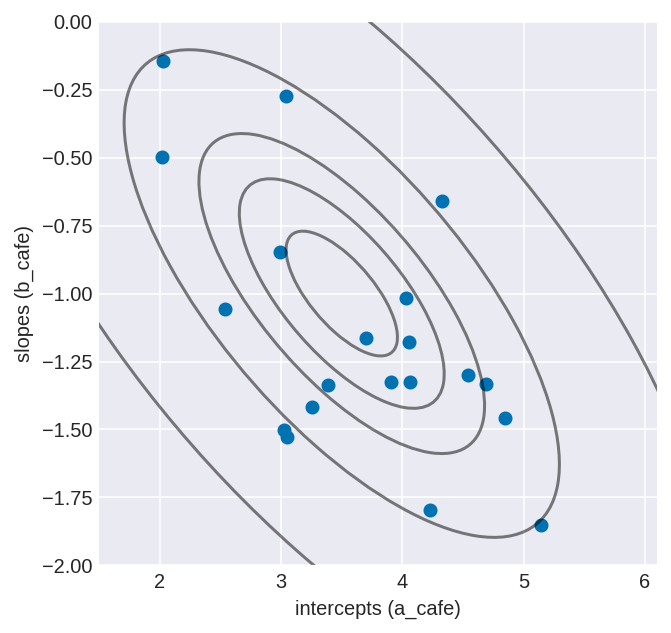

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax)
ax.scatter(a_cafe, b_cafe)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2, 0)
ax.set_xlabel('intercepts (a_cafe)')
ax.set_ylabel('slopes (b_cafe)');

#### Code 13.10

In [12]:
N_visits = 10
afternoon = np.tile([0,1], N_visits * N_cafes//2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)
# a_cafe[cafe_id] and b_cafe[cafe_id] repeats simulated model parameters
mu = a_cafe[cafe_id] + b_cafe[cafe_id]*afternoon
sigma = 0.5 # std dev within cafes
wait = np.random.normal(loc=mu, scale=sigma, size=N_visits*N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id , afternoon=afternoon , wait=wait))

In [13]:
d.head()

,cafe,afternoon,wait
0,0,0,3.359304
1,0,1,2.227004
2,0,0,2.932246
3,0,1,1.990768
4,0,0,2.250810


#### Code 13.11

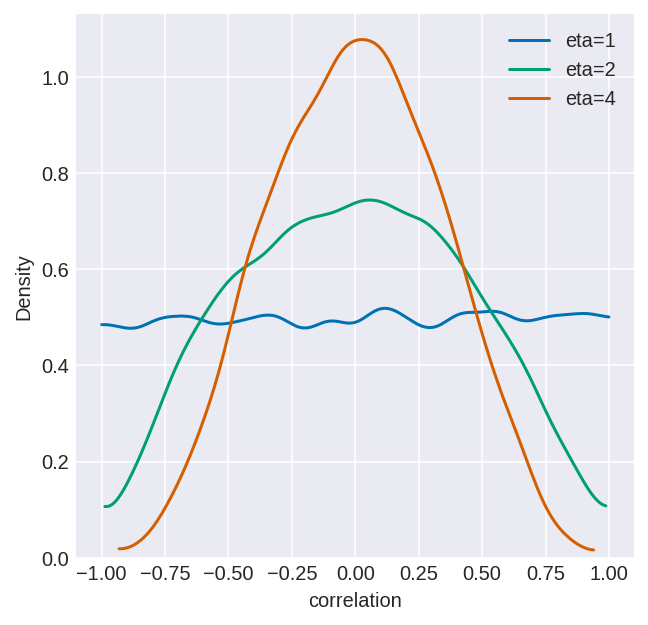

In [14]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
pm.kdeplot(pm.LKJCorr.dist(n=2, eta=1).random(size=10000), ax=ax, label='eta=1');
pm.kdeplot(pm.LKJCorr.dist(n=2, eta=2).random(size=10000), ax=ax, label='eta=2');
pm.kdeplot(pm.LKJCorr.dist(n=2, eta=4).random(size=10000), ax=ax, label='eta=4');
ax.set_xlabel('correlation')
ax.set_ylabel('Density');
ax.legend();

#### Code 13.12

In [15]:
# # example of calculations in model but using numpy
# temp_cov = np.cov(np.random.normal(size=(3,15)),np.random.normal(size=(3,15)))
# print(temp_cov)
# print('-------------------------------------')
# sigma_ab_temp = np.sqrt(np.diag(temp_cov))
# print(sigma_ab_temp)
# print('-------------------------------------')
# # tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
# corr_temp = np.diag(sigma_ab_temp**-1).dot(temp_cov.dot(np.diag(sigma_ab_temp**-1)))
# print(corr_temp)
# print('-------------------------------------')
# print(corr_temp[np.triu_indices(2, k=1)])
# print(np.triu_indices(2, k=1))

In [16]:
cafe_idx = d['cafe'].values

In [19]:
array_test = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
array_test

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [20]:
np.triu(array_test, -1)

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 0,  8,  9],
       [ 0,  0, 12]])

In [23]:
corr_triu_test = np.array([[np.nan,0.5],[np.nan,np.nan]])
corr_triu_test

array([[nan, 0.5],
       [nan, nan]])

In [24]:
corr_triu_test[np.zeros((2, 2), dtype=np.int64)]

array([[[nan, 0.5],
        [nan, 0.5]],

       [[nan, 0.5],
        [nan, 0.5]]])

In [35]:
a = pm.LKJCorr.dist(n=3, eta=1).random(size=1)

In [50]:
a

array([[ 0.03015337, -0.68898813, -0.22360487]])

In [43]:
n_dim=3

In [60]:
out = np.zeros([n_dim, n_dim])
out

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [59]:
out[np.triu_indices(3, k=1)]=a + out[np.triu_indices(3, k=1)].T

array([ 0.06030674, -1.37797626, -0.44720973])

In [55]:
out[np.triu_indices(3, k=1)] = a
out

array([[ 0.        ,  0.03015337, -0.68898813],
       [ 0.        ,  0.        , -0.22360487],
       [ 0.        ,  0.        ,  0.        ]])

In [56]:
out = out + out.T
out

array([[ 0.        ,  0.03015337, -0.68898813],
       [ 0.03015337,  0.        , -0.22360487],
       [-0.68898813, -0.22360487,  0.        ]])

In [57]:
np.fill_diagonal(out,1)

In [58]:
out

array([[ 1.        ,  0.03015337, -0.68898813],
       [ 0.03015337,  1.        , -0.22360487],
       [-0.68898813, -0.22360487,  1.        ]])

In [68]:
dim=2

In [69]:
# We will use separate priors for sigma and correlation matrix.
# In order to convert the upper triangular correlation values to a
# complete correlation matrix, we need to construct an index matrix:
n_elem = dim * (dim - 1) / 2
tri_index = np.zeros([dim, dim], dtype=int)
tri_index[np.triu_indices(dim, k=1)] = np.arange(n_elem)
tri_index[np.triu_indices(dim, k=1)[::-1]] = np.arange(n_elem)


In [74]:
with pm.Model() as m_13_1_alt:
    sigma = pm.HalfCauchy('sigma',beta=2,shape=1)
    corr_triu = pm.LKJCorr('corr_triu', n=corr_dim, eta=2)
    corr = pm.Deterministic('corr', tt.fill_diagonal(corr_triu[tri_index], 1.))
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, corr, sigma_diag))

ValueError: shapes (1,1) and (2,2) not aligned: 1 (dim 1) != 2 (dim 0)

In [71]:
corr

corr

In [ ]:
a
    
    sd_dist = pm.HalfCauchy.dist(beta=2) # This is the same as sigma_cafe ~ dcauchy(0,2)
    # it is more computationaly efficient to use a prior on the cholesky decomposition component
    # L. L is a lower tringular matrix and in this packed form it's a vector
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    # to calculate the covariance matric we re-pack the `packed_chol` vector to the 
    # matrix form of L of the cholesky decomposition 
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    # Cholesky composition of covariance
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    # convert covariance matrix to corellation matrix and get the corellation using `np.triu' 
    # see https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sigma', beta=2)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    trace_13_1 = pm.sample(5000, tune=2000)

In [ ]:
with pm.Model() as m_13_1:
    sd_dist = pm.HalfCauchy.dist(beta=2) # This is the same as sigma_cafe ~ dcauchy(0,2)
    # it is more computationaly efficient to use a prior on the cholesky decomposition component
    # L. L is a lower tringular matrix and in this packed form it's a vector
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    # to calculate the covariance matric we re-pack the `packed_chol` vector to the 
    # matrix form of L of the cholesky decomposition 
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    # Cholesky composition of covariance
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_cafe', tt.sqrt(tt.diag(cov)))
    # convert covariance matrix to corellation matrix and get the corellation using `np.triu' 
    # see https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    ab = pm.Normal('ab', mu=0, sd=10, shape=2)  # prior for average intercept and slope
    ab_cafe = pm.MvNormal('ab_cafe', mu=ab, chol=chol, shape=(N_cafes, 2)) # Population of varying effects
    # Shape needs to be (N_cafes, 2) because we're getting back both a and b for each cafe
    
    mu = ab_cafe[:, 0][cafe_idx] + ab_cafe[:, 1][cafe_idx] * d['afternoon'].values  # linear model
    sd = pm.HalfCauchy('sigma', beta=2)      # prior stddev within cafes
    wait = pm.Normal('wait', mu=mu, sd=sd, observed=d['wait'])  # likelihood
    trace_13_1 = pm.sample(5000, tune=2000)

For complicate model it is always good to do more checks:

In [ ]:
pm.traceplot(trace_13_1, varnames=['ab', 'Rho', 'sigma', 'sigma_cafe'],
             lines={"ab": Mu,
                    "Rho": rho,
                    "sigma": sigma,
                    "sigma_cafe": sigmas});

#### Code 13.13

In [ ]:
post = pm.trace_to_dataframe(trace_13_1)

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
R = pm.LKJCorr.dist(n=2, eta=2).random(size=10000)
pm.kdeplot(R, ax=ax, color='k', linestyle='--')
ax.text(0, .8, 'prior', horizontalalignment='center')
pm.kdeplot(trace_13_1['Rho'], ax=ax, color='C0')
ax.text(-.15, 1.5, 'posterior', color='C0', horizontalalignment='center')
ax.set_ylim(-.025, 2.5)
ax.set_xlabel('correlation', fontsize=14)
ax.set_ylabel('Density', fontsize=14);

#### Code 13.14

In [ ]:
# compute unpooled estimates directly from data
a1b1 = (d.groupby(['afternoon', 'cafe'])
        .agg('mean')
        .unstack(level=0)
        .values)
# mean wait times in the morning (afternoon=0)
a1 = a1b1[:, 0]
# difference between afternoon and morning (this would be the slope of the model)
b1 = a1b1[:, 1] - a1

# extract posterior means of partially pooled estimates
a2b2 = trace_13_1['ab_cafe'].mean(axis=0)
a2 = a2b2[:, 0]
b2 = a2b2[:, 1]

# plot both and connect with lines
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(a1, b1, label= 'unpooled estimates')
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1, label='pooled posterior estimates')

ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14);
ax.legend();

#### Code 13.15

In [ ]:
plt.rcParams.update({'font.size': 14})
# from the model
chol_model = pm.expand_packed_triangular(2, trace_13_1['chol_cov'].mean(0),lower=True).eval()
cov_model = np.dot(chol_model, chol_model.T)
# from the book
sa_est = trace_13_1['sigma_cafe'].mean(0)[0]
sb_est = trace_13_1['sigma_cafe'].mean(0)[1]
rho_est = trace_13_1['Rho'].mean()
cov_ab = sa_est * sb_est * rho_est
cov_book = np.array([sa_est**2, cov_ab, cov_ab, sb_est**2]).reshape(2,2)
# compute posterior mean bivariate Gaussian
Mu_est = trace_13_1['ab'].mean(axis=0)
Chol_cov = trace_13_1['chol_cov'].mean(axis=0)
L_chol = np.zeros((2, 2))
L_chol[np.tril_indices(2, 0)] = Chol_cov
Sigma_est = np.dot(L_chol, L_chol.T)
# draw contours
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for ls, cov_ in zip(['-','--',':'],[Sigma_est, cov_model, cov_book]):
    Gauss2d(Mu_est, np.asarray(cov_), [0.1, 0.3, 0.5, 0.8, 0.99], ax=ax, ls=ls)
ax.scatter(a1, b1)
ax.scatter(a2, b2, 
           facecolors='none', edgecolors='k', lw=1)
ax.plot([a1, a2], [b1, b2], 'k-', alpha=.5)
ax.set_xlabel('intercept', fontsize=14)
ax.set_ylabel('slope', fontsize=14)
ax.set_xlim(1.5, 6.1)
ax.set_ylim(-2.5, 0);

#### Code 13.16

In [ ]:
# convert varying effects to waiting times
wait_morning_1 = a1
wait_afternoon_1 = a1 + b1
wait_morning_2 = a2
wait_afternoon_2 = a2 + b2

#### Code 13.17

In [ ]:
d_ad = pd.read_csv('./Data/UCBadmit.csv', sep=';')
d_ad['male'] = (d_ad['applicant.gender'] == 'male').astype(int)
d_ad['dept_id'] = pd.Categorical(d_ad['dept']).codes

In [ ]:
d_ad.head()

#### Code 13.18

In [ ]:
Dept_id = d_ad['dept_id'].values
Ndept = len(d_ad['dept_id'].unique())
with pm.Model() as m_13_2:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id] + bm * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_2 = pm.sample(4500, tune=500)

pm.summary(trace_13_2, alpha=.11).round(2)

#### Code 13.19

In [ ]:
with pm.Model() as m_13_3:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('ab_cafe', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    bm_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * d_ad['male'])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_3 = pm.sample(5000, tune=1000, njobs=4)

#### Code 13.20

In [ ]:
pm.forestplot(trace_13_3, varnames=['bm_dept', 'a_dept'], alpha=.11);

In [ ]:
fig, ax = plt.subplots()
pm.kdeplot(trace_13_3['Rho'], ax=ax);
ax.set_xlabel('Rho');

#### Code 13.21

In [ ]:
with pm.Model() as m_13_4:
    a = pm.Normal('a', 0, 10)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id])
    admit = pm.Binomial('admit', p=p, n=d_ad.applications, observed=d_ad.admit)
    
    trace_13_4 = pm.sample(4500, tune=500)

In [ ]:
comp_df = pm.compare({m_13_2:trace_13_2,
                      m_13_3:trace_13_3,
                      m_13_4:trace_13_4})

comp_df.loc[:,'model'] = pd.Series(['m13.2', 'm13.3', 'm13.4'])
comp_df = comp_df.set_index('model')
comp_df

#### Code 13.22

In [ ]:
d = pd.read_csv('Data/chimpanzees.csv', sep=";")
# we change "actor" and "block" to zero-index
actor = (d['actor'] - 1).values
block = (d['block'] - 1).values
Nactor = len(np.unique(actor))
Nblock = len(np.unique(block))

with pm.Model() as model_13_6:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    
    beta_actor = pm.MvNormal('beta_actor', mu=0., chol=chol1, shape=(Nactor, 3))
    beta_block = pm.MvNormal('beta_block', mu=0., chol=chol2, shape=(Nblock, 3))

    A = Intercept[0] + beta_actor[actor, 0] + beta_block[block, 0]
    BP = Intercept[1] + beta_actor[actor, 1] + beta_block[block, 1]
    BPC = Intercept[2] + beta_actor[actor, 2] + beta_block[block, 2]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6 = pm.sample(5000, tune=1000)

In [ ]:
# pm.summary(trace_13_6).round(2)

#### Code 13.23

In [ ]:
with pm.Model() as model_13_6NC:
    sd_dist = pm.HalfCauchy.dist(beta=2)
    pchol1 = pm.LKJCholeskyCov('pchol_actor', eta=4, n=3, sd_dist=sd_dist)
    pchol2 = pm.LKJCholeskyCov('pchol_block', eta=4, n=3, sd_dist=sd_dist)
    chol1 = pm.expand_packed_triangular(3, pchol1, lower=True)
    chol2 = pm.expand_packed_triangular(3, pchol2, lower=True)
    
    Intercept = pm.Normal('intercept', 0., 1., shape=3)
    # A Cholesky decomposition L is a way to represent a square, symmetric matrix like a correlation matrix R 
    # such that R = LL.T. It is a marvelous fact that you can multiply L by a vector of uncorrelated samples and
    # end up with a vector of correlated samples. This is the trick that lets us take even the correlations out
    # of the prior. We just sample a vector of uncorrelated z-scores and then multiply those by the Cholesky
    # factor and the standard deviations to get the varying effects with the correct scale and correlation.
    b1 = pm.Normal('b1', 0., 1., shape=(3, Nactor))
    b2 = pm.Normal('b2', 0., 1., shape=(3, Nblock))
    beta_actor = tt.dot(chol1, b1)
    beta_block = tt.dot(chol2, b2)

    A = Intercept[0] + beta_actor[0, actor] + beta_block[0, block]
    BP = Intercept[1] + beta_actor[1, actor] + beta_block[1, block]
    BPC = Intercept[2] + beta_actor[2, actor] + beta_block[2, block]
    
    p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_13_6NC = pm.sample(5000, tune=1000)

#### Code 13.24

In [ ]:
# extract n_eff values for each model
neff_c = pm.summary(trace_13_6)['n_eff'].values
neff_nc = pm.summary(trace_13_6NC)['n_eff'].values
# plot distributions
_, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.boxplot([neff_c, neff_nc], labels=['m13.6', 'm13.6NC']);
ax.set_xlabel('model', fontsize=14)
ax.set_ylabel('effective samples', fontsize=14);

#### Code 13.25

Have no idea what's happening here. Probably some smart indexing to reproduce the covariance from the 3-d cholesky decomp matrices

In [ ]:
# I didnt compute the sigma from the chol above, got to get a bit more creative here
def unpack_sigma(pack_chol):
    idxs = np.tril_indices(3)
    chol_ = np.zeros((3, 3, pack_chol.shape[0]))
    chol_[idxs] = pack_chol.T
    chol = np.transpose(chol_, (2, 0, 1))
    cholt= np.transpose(chol, (0, 2, 1))
    sigma = np.matmul(chol, cholt)
    return np.sqrt(np.diagonal(sigma, axis1=1, axis2=2))

sigmadict = dict(Sigma_actor=unpack_sigma(trace_13_6NC.get_values('pchol_actor', combine=True)),
                 Sigma_block=unpack_sigma(trace_13_6NC.get_values('pchol_block', combine=True)))
trace_13_6NC.add_values(sigmadict)
pm.summary(trace_13_6NC, varnames=['Sigma_actor', 'Sigma_block']).round(2)

In [ ]:
pm.summary(trace_13_6NC, varnames=['Sigma_actor', 'Sigma_block']).round(2)

#### Code 13.26
R and Rethinking related, skip for now

#### Code 13.27

In [ ]:
with pm.Model() as m_12_5:
    bp = pm.Normal('bp', 0, 10)
    bpC = pm.Normal('bpC', 0, 10)
    
    a = pm.Normal('a', 0, 10)
    sigma_actor = pm.HalfCauchy('sigma_actor', 1.)
    a_actor = pm.Normal('a_actor', 0., sigma_actor, shape=Nactor)

    sigma_block = pm.HalfCauchy('sigma_block', 1.)
    a_block = pm.Normal('a_block', 0., sigma_block, shape=Nblock)
    
    p = pm.math.invlogit(a + a_actor[actor] + a_block[block]
                         + (bp + bpC * d['condition']) * d['prosoc_left'])
    pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

    trace_12_5 = pm.sample(6000, tune=1000)

In [ ]:
comp_df = pm.compare({model_13_6NC:trace_13_6NC,
                     m_12_5:trace_12_5},
                     method='pseudo-BMA')

comp_df.loc[:,'model'] = pd.Series(['m13.6NC', 'm12.5'])
comp_df = comp_df.set_index('model')
comp_df

#### Code 13.28
Actually in model m_13_6NC I am already using the Cholesky decomposition of the covariance matrix. If we want to strictly follow the parameterization of m13.6NC and m13.6nc1 as in the book, we will model the Rho using pm.LKJCorr and do multiplication it with pm.HalfCauchy.

In [ ]:
# effort to do it as in the books
# with pm.Model() as model_13_6nc1:
#     rho = pm.LKJCorr('rho', n=3, eta=4)
    
#     Intercept = pm.Normal('intercept', 0., 1., shape=3)
#     # note that in the book dmvnorm2 takes a vector of means, the sd_dist and 
#     # a prior from 
#     zeta_actor = pm.MvNormal('zeta_actor', mu=0., cov=chol1, shape=(Nactor, 3))
#     zeta_block = pm.MvNormal('zeta_block', mu=0., chol=chol2, shape=(Nblock, 3))
    
#     sigma_actor = pm.HalfCauchy('sigma_actor', beta=2, shape=3)
#     sigma_block = pm.HalfCauchy('sigma_block', beta=2, shape=3)

#     A = Intercept[0] + zeta_actor[actor, 0]*sigma_actor[0] + zeta_block[block, 0]*sigma_block[0]
#     BP = Intercept[1] + zeta_actor[actor, 1]*sigma_actor[1] + zeta_block[block, 1]*sigma_block[1]
#     BPC = Intercept[2] + zeta_actor[actor, 2]*sigma_actor[2] + zeta_block[block, 2]*sigma_block[2]
    
#     p = pm.math.invlogit(A + (BP + BPC*d['condition'])*d['prosoc_left'])
#     pulled_left = pm.Binomial('pulled_left', 1, p, observed=d['pulled_left'])

#     trace_13_6nc1 = pm.sample(5000, tune=1000)

#### Code 13.29

In [ ]:
Dmat = pd.read_csv('Data/islandsDistMatrix.csv', sep=",", index_col=0)
Dmat.round(1)

#### Code 13.30

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
xrange = np.linspace(0, 4, 100)
ax.plot(xrange, np.exp(-1*xrange), 'k--')
ax.plot(xrange, np.exp(-1*xrange**2), 'k')
ax.set_xlabel('distance', fontsize=14)
ax.set_ylabel('correlation', fontsize=14);

#### Code 13.31

In [ ]:
dk = pd.read_csv('Data/Kline2.csv', sep=",")
Nsociety = dk.shape[0]
dk.loc[:, 'society'] = np.arange(Nsociety)
Dmat_ = Dmat.values
Dmatsq = np.power(Dmat_, 2)

In [ ]:
with pm.Model() as m_13_7:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq*(tt.exp(-rhosq*Dmatsq)+np.diag([.01]*Nsociety))
    
    g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp*dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7 = pm.sample(1000, tune=1000)

In [ ]:
pm.traceplot(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']);

A reparameterization of m13.7

In [ ]:
with pm.Model() as m_13_7_:
    etasq = pm.HalfCauchy('etasq', 1)
    rhosq = pm.HalfCauchy('rhosq', 1)
    Kij = etasq * (tt.exp(-rhosq * Dmatsq) + np.diag([.01] * Nsociety))
    
    # g = pm.MvNormal('g', mu=np.zeros(Nsociety), cov=Kij, shape=Nsociety)
    gmu = pm.Normal('gmu', 0., 1., shape=Nsociety)
    g = pm.Deterministic('g', tt.dot(tt.slinalg.cholesky(Kij), gmu))
    
    a = pm.Normal('a', 0, 10)
    bp = pm.Normal('bp', 0, 1)
    lam = pm.math.exp(a + g[dk.society.values] + bp * dk.logpop)
    obs = pm.Poisson('total_tools', lam, observed=dk.total_tools)
    trace_13_7_ = pm.sample(1000, tune=1000)

In [ ]:
pm.traceplot(trace_13_7_, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']);

#### Code 13.32

In [ ]:
pm.summary(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']).round(2)

In [ ]:
pm.summary(trace_13_7_, varnames=['g', 'a', 'bp', 'etasq', 'rhosq']).round(2)

#### Code 13.33

In [ ]:
post = pm.trace_to_dataframe(trace_13_7, varnames=['g', 'a', 'bp', 'etasq', 'rhosq'])
post_etasq = post['etasq'].values
post_rhosq = post['rhosq'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, 10, 200)

ax.plot(xrange, np.median(post_etasq) * np.exp(-np.median(post_rhosq) * xrange**2), 'k')
ax.plot(xrange, (post_etasq[:100][:, None] * np.exp(-post_rhosq[:100][:, None] * xrange**2)).T,
        'k', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance')
ax.set_ylabel('correlation');

#### Code 13.34

In [ ]:
# compute posterior median covariance among societies
Kij_post = np.median(post_etasq) * (np.exp(-np.median(post_rhosq) * Dmatsq) + np.diag([.01] * Nsociety))

#### Code 13.35

In [ ]:
# convert to correlation matrix
sigma_post = np.sqrt(np.diag(Kij_post))
Rho = np.diag(sigma_post**-1).dot(Kij_post.dot(np.diag(sigma_post**-1)))
# add row/col names for convenience
Rho = pd.DataFrame(Rho, index=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"],
                  columns=["Ml","Ti","SC","Ya","Fi","Tr","Ch","Mn","To","Ha"])

Rho.round(2)

#### Code 13.36

In [ ]:
# scale point size to logpop
logpop = np.copy(dk['logpop'].values)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)

_, ax = plt.subplots(1, 1, figsize=(5, 5))
# islands as dots with size proportional to population
ax.scatter(dk['lon2'], dk['lat'], psize);
# names of islands
labels = dk['culture'].values
for i, itext in enumerate(labels):
    ax.text(dk['lon2'][i]+1, dk['lat'][i]+1, itext)
# overlay lines shaded by Rho
for i in range(10):
    for j in np.arange(i+1, 10):
        ax.plot([dk['lon2'][i], dk['lon2'][j]],
                [dk['lat'][i], dk['lat'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude');

#### Code 13.37

In [ ]:
Nbin = 30
log_pop_seq = np.linspace(6, 14, Nbin)
a_post = trace_13_7.get_values(varname='a', combine=True)[:, None]
bp_post = trace_13_7.get_values(varname='bp', combine=True)[:, None]
# posterior without taking distance into account
lambda_post = np.exp(a_post + bp_post*log_pop_seq)

# plot raw data
_, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(log_pop_seq, np.median(lambda_post, axis=0), '--', color='k')

alpha = .2
mu_hpd = pm.hpd(lambda_post, alpha=alpha)
axes.fill_between(log_pop_seq,
                  mu_hpd[:,0], mu_hpd[:,1], alpha=alpha*.5+.1, color='k')

axes.scatter(dk['logpop'], dk['total_tools'], psize)
labels = dk['culture'].values
for i, itext in enumerate(labels):
    axes.text(dk['logpop'][i]+.1, dk['total_tools'][i]-2.5, itext)
    
# overlay correlations
for i in range(10):
    for j in np.arange(i+1, 10):
        axes.plot([dk['logpop'][i], dk['logpop'][j]],
                [dk['total_tools'][i], dk['total_tools'][j]], 'k-', 
                alpha=Rho.iloc[i, j]**2, lw=2.5)
        
axes.set_xlabel('log-population')
axes.set_ylabel('total tools')
axes.set_xlim(6.8, 12.8)
axes.set_ylim(10, 73);

#### Code 13.38
Practice session, skip for now.

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))